# Exercise 1: Convolution GAN for MNIST digits

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda


## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [3]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.99MB/s]


QUESTION: Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


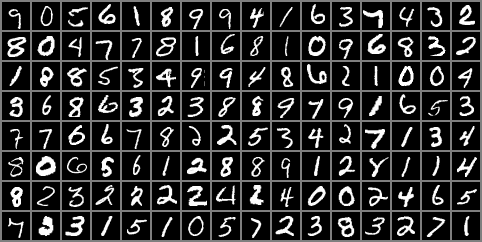

In [5]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture of DCGAN is described in the [(Radford et al., 2016)](https://arxiv.org/pdf/1511.06434.pdf)

QUESTION: Examine the architecture of the following generator and discriminator.

ANSWER : The generator takes a 100-dimensional vector (nz = 100) and upsamples it using a series of transposed convolutional layers. Each layer is followed by a batch normalization and a ReLU activations, except for the final layer, which uses a Tanh activation to produce an output image.

The generator increases the spatial dimensions from 1×1 up to 32×32. With the final convolution with a 1×1 kernel and padding, the output size is 36×36. This mismatch requires adjustment to match target image dimensions.

The discriminator is a convolutional neural network that takes a 1×28×28 image and downsamples it through several convolutional layers with LeakyReLU activations.


In [6]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 3 x 3
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


## Display Samples of the Generator

In [7]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

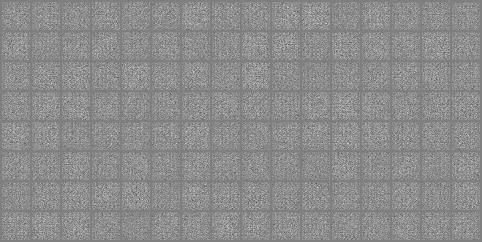

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

<br/><br/><br/><br/><br/>

# Part 1: DCGAN Training with WGAN-GP loss

<br/><br/>
**QUESTION:** Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

You may get inspiration from the function $\texttt{lipconstant}$ given below.

In [8]:

def gradient_penalty(D,x,y):
    ### ... ###
    b = x.shape[0]
    if y.shape[0]!=b:
        print('wrong size')
    alpha = torch.rand((b,1,1,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1)+ 1e-12)

    return torch.mean((gradients_norm - 1)**2)

def lipconstant(D,x,y):
    # Calculate interpolation between points in batches x and y (of same size b)
    b = x.shape[0]
    if y.shape[0]!=b:
        print('wrong size')
    alpha = torch.rand((b,1,1,1),device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
       create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1))

    # Return gradient penalty
    return torch.mean(gradients_norm)



y = next(iter(train_loader))[0].to(device)
x = G(torch.randn(batch_size, nz, 1, 1, device=device)).detach()

print(lipconstant(D,x,y))
print(gradient_penalty(D,x,y))

tensor(0.0440, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9045, device='cuda:0', grad_fn=<MeanBackward0>)


<br/><br/>

**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss to maximize <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss to minimize <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

[1/5][0/468][0.5221 s]	Loss_D: -0.2103	Loss_G: 0.3448	Lip(D): 0.0501


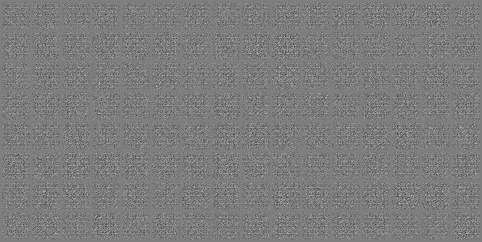

[1/5][100/468][8.4176 s]	Loss_D: -5.6133	Loss_G: 4.0583	Lip(D): 0.2618


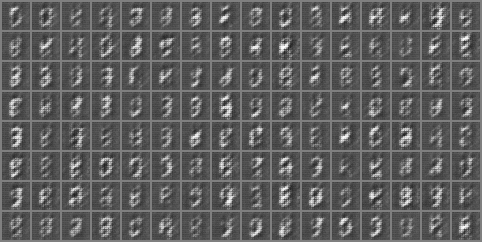

[1/5][200/468][16.1461 s]	Loss_D: -42.4341	Loss_G: 20.6491	Lip(D): 0.5963


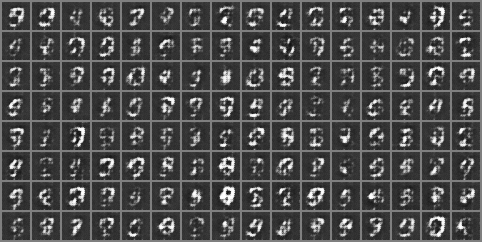

[1/5][300/468][24.0794 s]	Loss_D: -86.8740	Loss_G: 18.4456	Lip(D): 0.7458


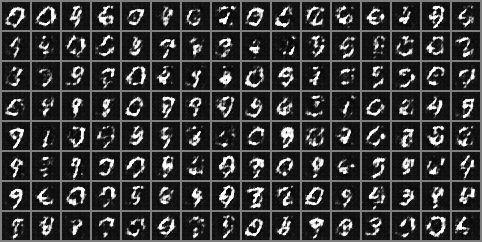

[1/5][400/468][32.0418 s]	Loss_D: -48.6814	Loss_G: 22.1156	Lip(D): 0.6111


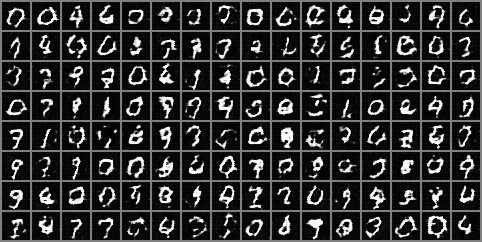

[2/5][0/468][37.6016 s]	Loss_D: -57.4003	Loss_G: 61.2872	Lip(D): 0.3585


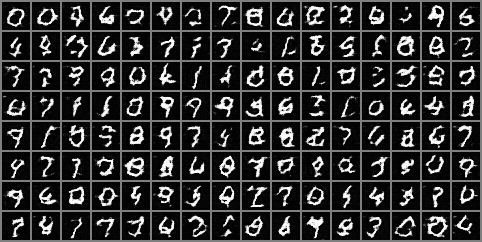

[2/5][100/468][46.1808 s]	Loss_D: -46.2179	Loss_G: 37.8028	Lip(D): 0.7386


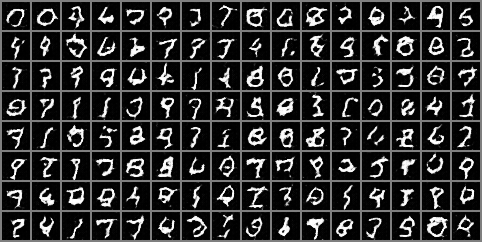

[2/5][200/468][54.1948 s]	Loss_D: -24.3776	Loss_G: 49.7795	Lip(D): 0.6026


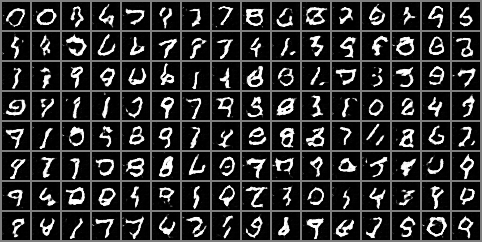

[2/5][300/468][62.4282 s]	Loss_D: -18.6320	Loss_G: 4.6302	Lip(D): 0.7478


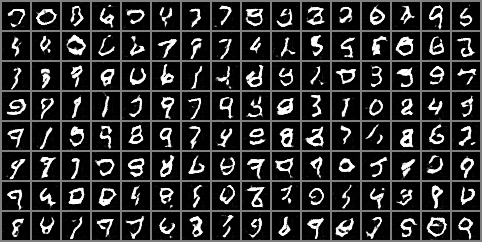

[2/5][400/468][70.6709 s]	Loss_D: 12.9172	Loss_G: 121.2804	Lip(D): 0.7322


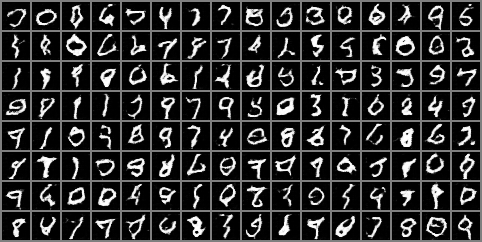

[3/5][0/468][76.3557 s]	Loss_D: -50.6726	Loss_G: 43.9595	Lip(D): 0.6489


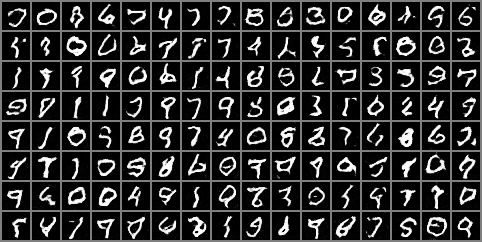

[3/5][100/468][84.6691 s]	Loss_D: -3.9646	Loss_G: 141.3999	Lip(D): 0.7245


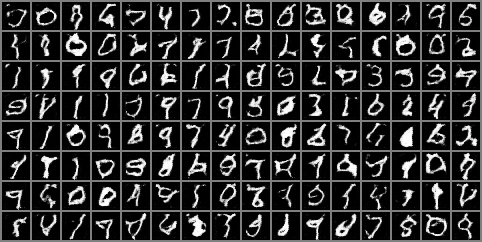

[3/5][200/468][92.9384 s]	Loss_D: -35.6733	Loss_G: 30.8981	Lip(D): 1.4051


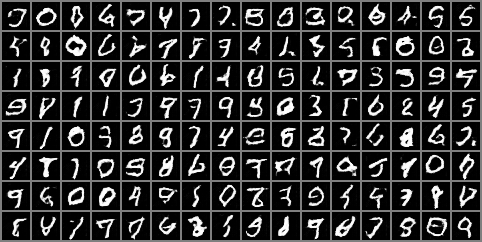

[3/5][300/468][101.1277 s]	Loss_D: -18.0701	Loss_G: 105.7035	Lip(D): 0.6870


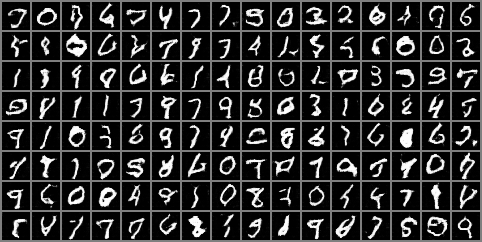

[3/5][400/468][109.4289 s]	Loss_D: -45.7085	Loss_G: 96.5924	Lip(D): 0.6981


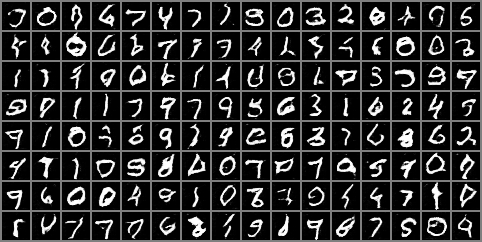

[4/5][0/468][115.1035 s]	Loss_D: -25.4621	Loss_G: 87.3934	Lip(D): 1.7217


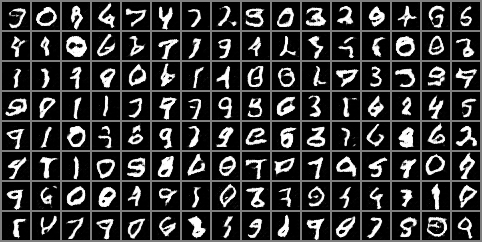

[4/5][100/468][123.3802 s]	Loss_D: -2.2781	Loss_G: 49.5604	Lip(D): 1.1134


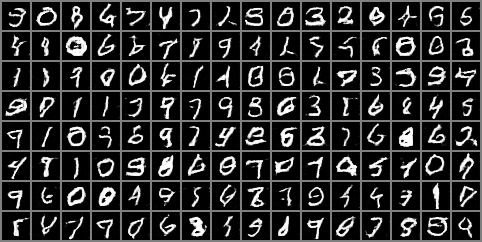

[4/5][200/468][131.6660 s]	Loss_D: -42.1010	Loss_G: 50.0080	Lip(D): 1.1856


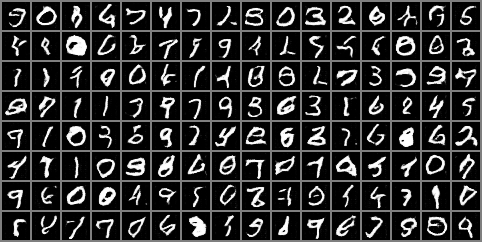

[4/5][300/468][139.7931 s]	Loss_D: -33.8659	Loss_G: -14.2871	Lip(D): 1.5925


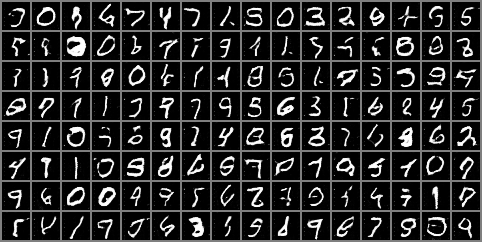

[4/5][400/468][148.0813 s]	Loss_D: -19.2074	Loss_G: 97.7003	Lip(D): 0.9972


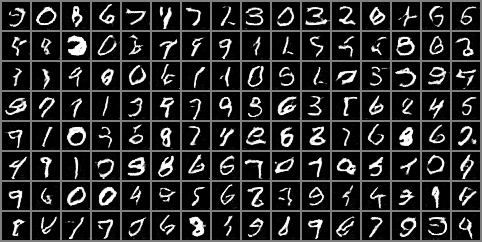

[5/5][0/468][153.8389 s]	Loss_D: -25.6767	Loss_G: 57.1829	Lip(D): 1.4061


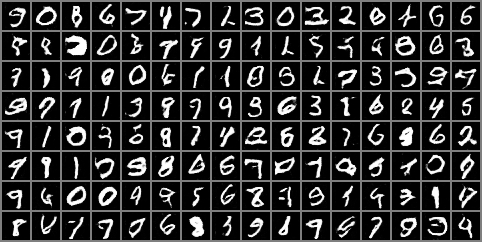

[5/5][100/468][162.0685 s]	Loss_D: -28.2081	Loss_G: 22.2330	Lip(D): 1.6021


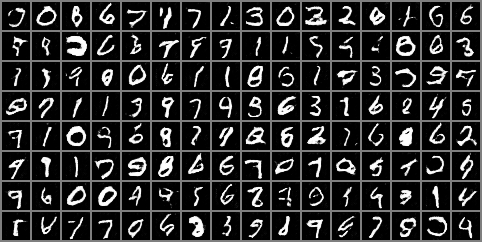

[5/5][200/468][170.3100 s]	Loss_D: -26.2934	Loss_G: 24.7359	Lip(D): 1.7280


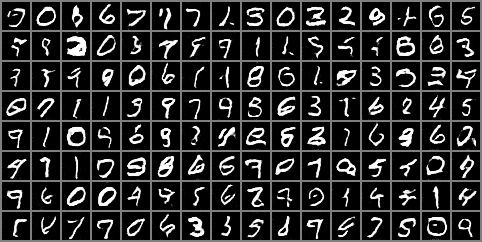

[5/5][300/468][178.5299 s]	Loss_D: 5.7208	Loss_G: 218.2687	Lip(D): 0.8386


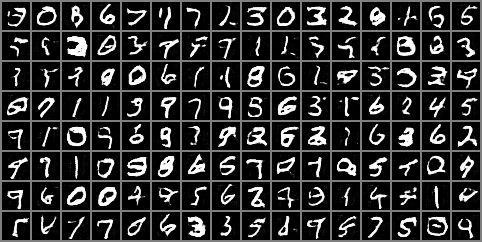

[5/5][400/468][186.7492 s]	Loss_D: -17.5682	Loss_G: 102.4025	Lip(D): 1.8684


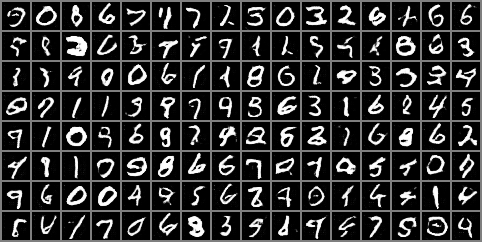

Total learning time =  192.3860764503479


<All keys matched successfully>

In [9]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update D network
        ### ... ###
        D.zero_grad()
        Dloss = -torch.mean(D(real)) + torch.mean(D(faked)) + gpw * gradient_penalty(D,real,faked)
        Dloss.backward()
        optimD.step()
        lip = lipconstant(D,real,faked)
        lip.detach()

        ############################
        # Update G network
        ### ... ###
        G.zero_grad()
        Gloss = -torch.mean(D(fake))
        Gloss.backward()
        optimG.step()
        lip = lipconstant(D,real,faked)
        lip.detach()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,real,faked)))
            show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


In [10]:
# Save final generator for later use
torch.save(G.state_dict(), 'wgan.pt')
wgan = Generator()
wgan.load_state_dict(G.state_dict())


<All keys matched successfully>

<br/><br/><br/><br/><br/>

# Part 2 BONUS: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

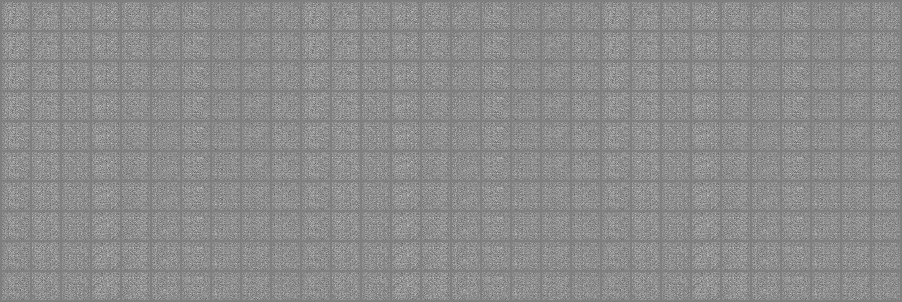

In [15]:
# You may load a trained generator from a file
# G = Generator().to(device)
# G.load_state_dict(torch.load('wgan_epoch100.pt'))
# G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10
nk = 30

z0 = torch.randn(minib, nz, 1, 1, device=device)
z1 = torch.randn(minib, nz, 1, 1, device=device)

genimages = torch.zeros((minib*nk,1,28,28))
for k in np.arange(nk):
    ### ... ###
    z = (1-k/nk) * z0 + k/nk * z1
    genimages[k*minib:(k+1)*minib,:,:,:] = G(z)


pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

## Nearest Neighbor in the Dataset

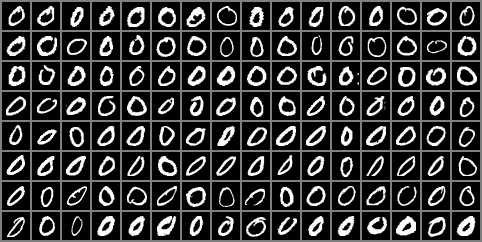

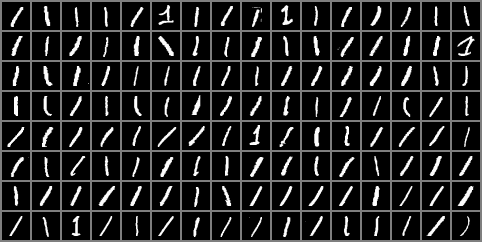

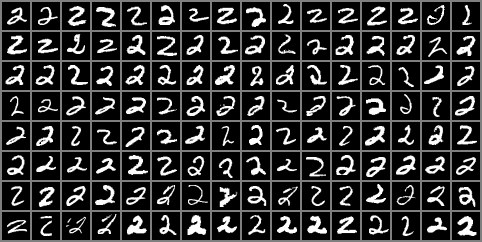

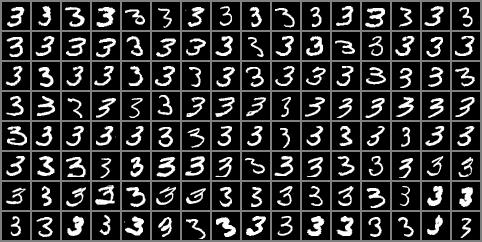

In [10]:
# load all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

In [11]:
### ... ###

num_samples = 10  # Number of samples to generate
z = torch.randn(num_samples, nz, 1, 1, device=device)  # Generate random latent vectors
gen_samples = G(z).detach().cpu()  # Generate samples using the generator

In [12]:
gen_samples_flat = gen_samples.view(num_samples, -1)  # Flatten generated samples
y_flat = y.view(y.shape[0], -1)  # Flatten dataset images
gen_samples_flat = gen_samples_flat / gen_samples_flat.norm(dim=1, keepdim=True)  # Normalize generated samples
y_flat = y_flat / y_flat.norm(dim=1, keepdim=True)  # Normalize dataset images

In [13]:
distances = torch.cdist(gen_samples_flat, y_flat)  # Calculate pairwise distances
nearest_neighbor_indices = distances.argmin(dim=1)  # Find indices of nearest neighbors
nearest_neighbors = y[nearest_neighbor_indices]  # Get nearest neighbor images

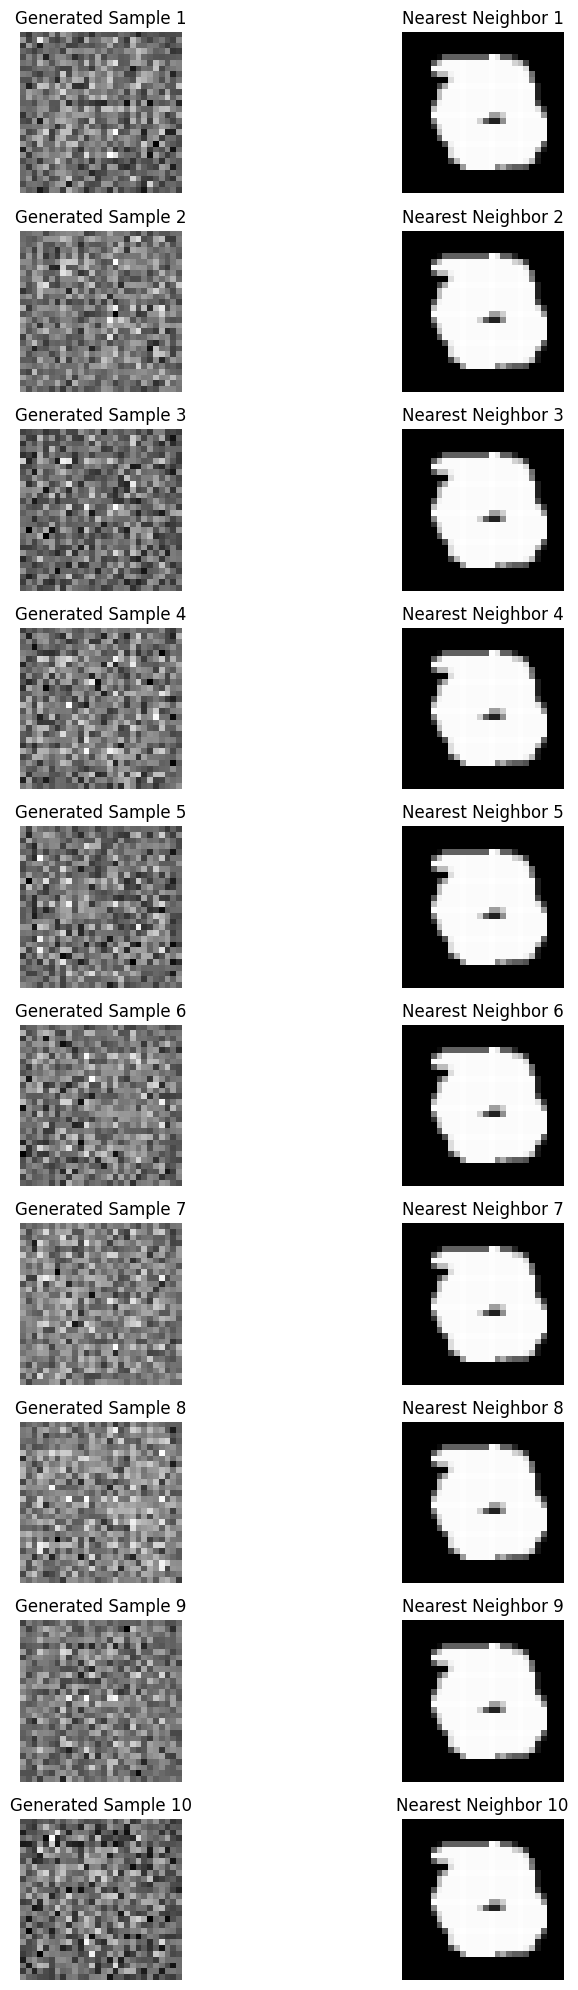

In [14]:
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))
for i in range(num_samples):
    axes[i, 0].imshow(gen_samples[i].squeeze(), cmap='gray')
    axes[i, 0].set_title(f'Generated Sample {i + 1}')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(nearest_neighbors[i].squeeze(), cmap='gray')
    axes[i, 1].set_title(f'Nearest Neighbor {i + 1}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()